<a href="https://colab.research.google.com/github/RahulJuluru2/aiml_hackathons/blob/main/U3_MH1_Plant_Images_Denoising_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Denoise the leaf images using deep learning techniques

## Learning Objectives

At the end of the Mini Hackathon, you will be able to :
* Denoise healthy/diseased leaf images using Autoencoder
* Visualize the denoised images

In [1]:
#@title Mini Hackathon Walkthrough Video
from IPython.display import HTML

HTML("""<video width="500" height="300" controls>
  <source src="https://cdn.talentsprint.com/talentsprint1/archives/sc/misc/M3_Mini_Hackathon1_Plant_Images_Denoising.mp4" type="video/mp4">
</video>
""")

## Background

Crop losses due to diseases are a major threat to food security every year, across countries.  Conventionally, plant diseases were detected through a visual examination of the affected plants by plant pathology experts. This was often possible only after major damage had already occurred, so treatments were of limited or no use. Recently, access to smartphone based image capturing has highly increased amongst farmers and agriculturists. This has led to the successful adoption of plant disease diagnostic applications based on deep learning techniques. This is of immense value in the field of agriculture and an excellent tool for faster identification and treatment of crop diseases. It holds key importance in preventing crop based food and economic losses. 
## Dataset and Methodology

The dataset for this Mini-Hackathon is derived from the 'Plant Village' Dataset.Around 4500 images of healthy and diseased leaves and their labels have been taken from the 'Plant Village' Dataset. The 4500 images consist of 5 different classes - Bell Pepper Healthy, Bell Pepper Bacterial Spot, Potato Healthy, Potato Early Blight and Potato Late Blight. The original pictures have been clicked in a well controlled environment with very less noise in the images. This is not how real world data may look like.  So we have added noise to the original images to form a noisy dataset. We can use deep learning techniques such as an autoencoder for obtaining denoised images. 


## References:

[Plant Village Dataset Description](https://drive.google.com/file/d/1xGhK-KhhE8W_lfr3l6KT_9K8prHDRb9_/view?usp=sharing)


[Deep Learning for Plant Disease Detection](https://drive.google.com/file/d/1V7NgFs-YGG3G-pz3OJf2X-KQxOGRZzRu/view?usp=sharing)

[Autoencoder motivational Expt](https://drive.google.com/file/d/1bjDAKSR9HNND-PQRJe7PDpk94mjSYIT4/view?usp=sharing)


## Grading = 20 Marks

## Setup Steps

In [2]:
#@title Run this cell to download the dataset

from IPython import get_ipython
ipython = get_ipython()
  
notebook="U3_MH2_Plant_Images_Denoising" #name of the notebook
Answer = "This notebook is graded by mentors on the day of hackathon"
def setup():
   ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/PlantVillage_Noisy_Dataset.zip")
   ipython.magic("sx unzip -qq PlantVillage_Noisy_Dataset.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


**Import Libraries**

In [3]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import tensorflow as tf

In [4]:
from glob import glob
from tifffile import imread
from skimage.transform import resize
import numpy as np
from torchsummary import summary

## **Stage 1:** Data Preparation

### 2 Marks - > Prepare the dataset

1. Define transformations:
   * Transform image size to 128 by using Resize()
   * Transform the image into a number using tensor
2. Load the dataset with the defined transformations.

In [5]:
# constants
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
BATCH_SIZE = 64

img_height , img_width = 128 , 128
transforms = transforms.Compose(
                  [transforms.Resize([img_height,img_width]),
                   transforms.ToTensor()])

In [6]:
# YOUR CODE HERE for preparing trainloader and testloader set
noise_train_data = datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Train_Data/',transform = transforms)
noise_test_data = datasets.ImageFolder('/content/PlantVillage/Noisy_Dataset/Test_Data/',transform = transforms)

pure_train_data = datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Train_Data/',transform = transforms)
pure_test_data = datasets.ImageFolder('/content/PlantVillage/Pure_Dataset/Test_Data/',transform = transforms)

In [7]:
print(f"{len(noise_train_data)} , {len(noise_test_data)}")
print(f"{len(pure_train_data)} , {len(pure_test_data)}")

3007 , 1613
3007 , 1613


In [8]:
# Loading the train dataset aand test dataset 
noise_train_data_loader = torch.utils.data.DataLoader(noise_train_data, batch_size=BATCH_SIZE)
noise_test_data_loader = torch.utils.data.DataLoader(noise_test_data, batch_size=BATCH_SIZE)
pure_train_data_loader = torch.utils.data.DataLoader(pure_train_data, batch_size=BATCH_SIZE)
pure_test_data_loader = torch.utils.data.DataLoader(pure_test_data, batch_size=BATCH_SIZE)

Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64])


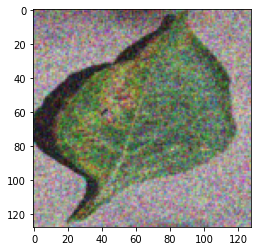

Label: 0
Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64])


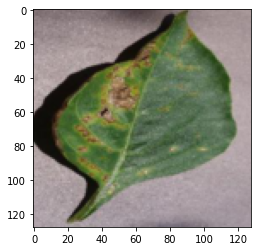

Label: 0


In [9]:
# Display image and label.
train_features, train_labels = next(iter(noise_train_data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(noise_train_data_loader)
plt.imshow(img.permute(1, 2, 0)) # In permute(1, 2, 0), 2 is the width; 1 is the height; 0 is the channel of the image
plt.show()
print(f"Label: {label}")

# Clean image
train_features, train_labels = next(iter(pure_train_data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(noise_train_data_loader)
plt.imshow(img.permute(1, 2, 0)) # In permute(1, 2, 0), 2 is the width; 1 is the height; 0 is the channel of the image
plt.show()
print(f"Label: {label}")

In [10]:
dataiter = iter(noise_train_data_loader)
images , labels = dataiter.next()
print(torch.min(images) , torch.max(images))

dataiter = iter(noise_test_data_loader)
images , labels = dataiter.next()
print(torch.min(images) , torch.max(images))

tensor(0.0157) tensor(0.9765)
tensor(0.0118) tensor(0.9569)


## **Stage 2:** Build and Train the Model



### 4 Marks -> Write the encoder and decoder layers in one class

* Define the Autoencoder neural network
    *  First define the layers required in the  __init__ function.
    *  Build the neural network in the forward() function.

[Hint for saving the images](https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/)

In [11]:
from torchvision.utils import save_image
import os

In [12]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        # Encoder
        # Defining the convolution layer with input_channels = 3, output_channels = 32, kernel_size = 2, padding =1
        self.conv1 = nn.Conv2d(3 , 32, 2, padding=1)  
        # Defining the convolution layer with input_channels = 32, output_channels = 64, kernel_size = 3, padding =1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Max pooling layer with filter size 2x2
        self.pool = nn.MaxPool2d(2, 2)
      
        
        # Decoder 
        # Defining the convolution layer with input_channels = 64, output_channels = 32, kernel_size = 3, stride =2
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 3, stride=2)
        # Defining the convolution layer with input_channels = 32, output_channels = 1, kernel_size = 2, stride =2
        self.t_conv2 = nn.ConvTranspose2d(32, 3, 2, stride=2)


    def forward(self, x):
        # Linear layers with RELU activation 
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.t_conv1(x))
        x = self.pool(x)
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

In [13]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [14]:
# get the computation device
device = get_device()
print(device)

# load the neural network onto the device
net = ConvAutoencoder().to(device)
summary(net,(3,128,128))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 129, 129]             416
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
   ConvTranspose2d-4         [-1, 32, 129, 129]          18,464
         MaxPool2d-5           [-1, 32, 64, 64]               0
   ConvTranspose2d-6          [-1, 3, 128, 128]             387
Total params: 37,763
Trainable params: 37,763
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 12.50
Params size (MB): 0.14
Estimated Total Size (MB): 12.83
----------------------------------------------------------------


### 4 Marks -> Train the Model and calculate the loss for dataset for each epoch.

1. Declare the loss function and optimizer
2. Create a directory for saving the output images.
2. Train the model
   *  Extract the image features only as we do not take the labels to train the autoencoder network.
   * Calculate the loss.
   * Append the loss values after every epoch and print them.
   * Save the output (denoised) images in a directory. 

In [15]:
# YOUR CODE HERE for declaring the loss function and optimizer 
# Initialization of Mean Square Error
criterion = nn.MSELoss()

# Initialization of Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [16]:
def make_dir(image_dir):
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

def save_decoded_image(images, name):
    # batch of 
    print(images.shape)
    for i in range(BATCH_SIZE-1):
        img = images[i]
        img = img.permute(1, 2, 0)
        plt.imshow(img) # In permute(1, 2, 0), 2 is the width; 1 is the height; 0 is the channel of the image
        plt.show()
    
        # save_image(img, name)

In [17]:
# Creating directory
image_dir = 'GeneratedOutput'
make_dir(image_dir)

In [18]:
train_loss = []
output_images = []
#NUM_EPOCHS =1
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0

    for noiseImageData, pureImageData in zip(noise_train_data_loader, pure_train_data_loader):
        noiseimg , _ = noiseImageData
        pureimg, _ = pureImageData
        
        # extracting image feature only
        noiseimg = noiseimg.to(device)
        pureimg = pureimg.to(device)
        optimizer.zero_grad()
        
        outputs = net(noiseimg)
        loss = criterion(outputs, pureimg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if epoch == NUM_EPOCHS - 1:
          with torch.no_grad():
            output_images.append(outputs.cpu().numpy())
    loss = running_loss / len(noise_train_data_loader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, NUM_EPOCHS, loss))

Epoch 1 of 10, Train Loss: 0.011
Epoch 2 of 10, Train Loss: 0.004
Epoch 3 of 10, Train Loss: 0.003
Epoch 4 of 10, Train Loss: 0.003
Epoch 5 of 10, Train Loss: 0.002
Epoch 6 of 10, Train Loss: 0.002
Epoch 7 of 10, Train Loss: 0.002
Epoch 8 of 10, Train Loss: 0.002
Epoch 9 of 10, Train Loss: 0.002
Epoch 10 of 10, Train Loss: 0.002


In [19]:
counts = 0
for i in range(len(output_images)):
  counts += output_images[i].shape[0]
counts

3007

In [20]:
from torchvision.utils import save_image

In [21]:
def to_img(x):
    x = x.clip(0, 1)
    x = x.reshape(3, 128,128)
    return x

In [22]:
counter = 0
for i in range(len(output_images)):
  for j in range(len(output_images[i])):
    tensor = output_images[i][j]
    # print(tensor)
    save = to_img(tensor)
    counter += 1
    save_image(torch.Tensor(save), './GeneratedOutput/image_{}.png'.format(counter))

In [23]:
!ls /content/GeneratedOutput | wc -l

3007


## **Stage 3:** Visualize the Denoised images 

### 3 Marks -> Verify the denoised images and compare with original noisy images
1. Plot the original noisy images.
2. Plot denoised images which are saved in the directory.
3. Verify whether denoised images have less noise compared to original noisy images

**Hint:** If the noise is not reduced in the denoised images then revise the autoencoder architecture.

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


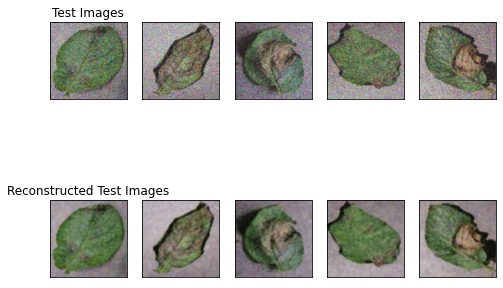

In [24]:
f, a = plt.subplots(2, 5, figsize=(8,6))
for i in range(5):
  # a[0,i].imshow(noiseimg[i].detach().cpu().numpy().reshape(128,128,3))
  print(noiseimg[i].detach().cpu().data.shape)
  a[0,i].imshow(noiseimg[i].detach().cpu().data.permute(1, 2, 0))
  a[0,i].set_xticks(()); 
  a[0,i].set_yticks(())
  a[0,0].title.set_text('Test Images')
  

for i in range(5):
  print(outputs[i].detach().cpu().data.shape)
  a[1,i].imshow(outputs[i].detach().cpu().data.permute(1, 2, 0))
  a[1,i].set_xticks(())
  a[1,i].set_yticks(())
  a[1,0].title.set_text('Reconstructed Test Images')

plt.show()

## **Stage 4:** Test the Model

### 4 Marks -> Evaluate model with the given test data

1. Extract only the images of test loader data as we do not use the labels for the autoencoder network
2. Pass the test images through the autoencoder model to get the denoised images of the test data. 
3. Calculate the loss of the test images

In [25]:
net.eval()

ConvAutoencoder(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [26]:
running_loss = 0.0
with torch.no_grad():
  for test_noiseImageData, test_pureImageData in zip(noise_test_data_loader, pure_test_data_loader):
      test_noiseimg , _ = test_noiseImageData
      test_pureimg, _ = test_pureImageData
      
      # extracting image feature only
      test_noiseimg = test_noiseimg.to(device)
      test_pureimg = test_pureimg.to(device)
      
      outputs2 = net(test_noiseimg)
      loss = criterion(outputs2, test_pureimg)
      
      running_loss += loss.item()

  loss = running_loss / len(noise_train_data_loader)
  print('Test Loss: {:.3f}'.format(loss))

Test Loss: 0.001


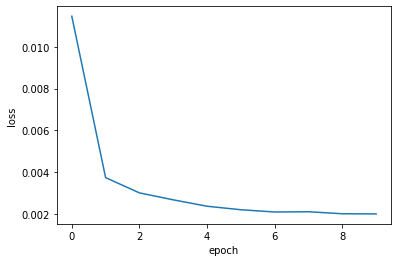

In [27]:
epochs = np.arange(0,NUM_EPOCHS)
plt.plot(epochs,train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

### 3 Marks -> Visualizing and verifying test images with the original test noisy dataset

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


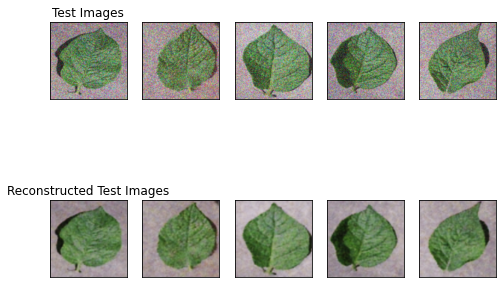

In [28]:
f, a = plt.subplots(2, 5, figsize=(8,6))
for i in range(5):
  # a[0,i].imshow(noiseimg[i].detach().cpu().numpy().reshape(128,128,3))
  print(test_noiseimg[i].detach().cpu().data.shape)
  a[0,i].imshow(test_noiseimg[i].detach().cpu().data.permute(1, 2, 0))
  a[0,i].set_xticks(()); 
  a[0,i].set_yticks(())
  a[0,0].title.set_text('Test Images')
  

for i in range(5):
  print(outputs2[i].detach().cpu().data.shape)
  a[1,i].imshow(outputs2[i].detach().cpu().data.permute(1, 2, 0))
  a[1,i].set_xticks(())
  a[1,i].set_yticks(())
  a[1,0].title.set_text('Reconstructed Test Images')

plt.show()